# Outline

- [Part 0:  model architecture](#0) 


- [Part 1:  import packages](#1) 
    
    
- [Part 2:  prepare functions](#2)

    - [2.1  create train & validation generators function](#2.1)
    - [2.2  build model function](#2.2)
    - [2.3  learning rate scadular](#2.3)
    - [2.4  model training function](#2.4)
    - [2.5  load test data](#2.5)
    - [2.6  draw training graph function](#2.6)
    - [2.7  draw confusion_matrix function](#2.7)
    - [2.8  print classification report function](#2.8)
    - [2.8  draw ROC curve functions](#2.9)
   
    
- [Part 3:  train the model on the original data](#3)

    - [3.1  model on imbalanced data](#3.1)
        - [3.1.1  model summary](#3.1.1)
        - [3.1.2  train the model](#3.1.2)
        - [3.1.3  train graphs](#3.1.3)
        - [3.1.4  test results](#3.1.4)
        
    - [3.2  model on oversampled data](#3.2)
        - [3.2.1  model summary](#3.2.1)
        - [3.2.2  train the model](#3.2.2)
        - [3.2.3  train graphs](#3.2.3)
        - [3.2.4  test results](#3.2.4)
        
    - [3.3  model on undersampled data](#3.3)
        - [3.3.1  model summary](#3.3.1)
        - [3.3.2  train the model](#3.3.2)
        - [3.3.3  train graphs](#3.3.3)
        - [3.3.4  test results](#3.3.4)



<a name="0"></a>
##  <span style="color:blue"> **model architecture** </span>

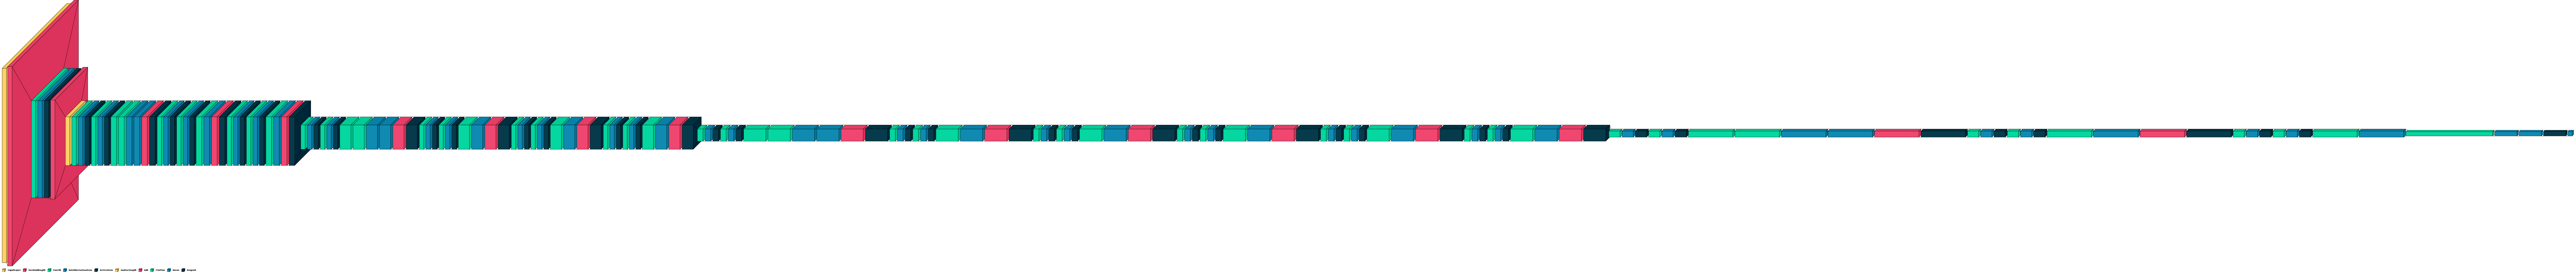

In [41]:
visualkeras.layered_view(model1,legend=True)

<a name="1"></a>
##  <span style="color:blue"> **import packages** </span>

In [1]:
import numpy as np
from tqdm import tqdm
import glob
import pickle
import math
import gc

#for model
import visualkeras
import tensorflow as tf
from tensorflow.math import exp
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint ,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, BatchNormalization , Dropout,Flatten ,Rescaling  ,Resizing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.test import is_built_with_cuda
from tensorflow.keras.models import load_model

#for model evaluation and visualization
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report,roc_curve,roc_auc_score, f1_score

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# to avoid gpu errors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
is_built_with_cuda()

True

<a name="2"></a>
##  <span style="color:blue"> **prepare functions** </span>

<a name="2.1"></a>

In [8]:
# build train & validation generator 
def create_generators(train_path):
    train_datagen  = ImageDataGenerator(
                                        rescale=1 / 255.0,
                                        rotation_range=30,
                                        zoom_range = 0.2,
                                        validation_split=0.25)

    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='training',
        shuffle=True,
    )

    valid_datagen=ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    validation_split=0.25)

    valid_generator = valid_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='validation',
        shuffle=True,
    )
    return train_generator ,valid_generator

<a name="2.2"></a>

In [5]:
def build_model():
    model = ResNet50V2(include_top=False ,input_shape=(224,224,3) , weights="imagenet")

    base_input= model.layers[0].input
    base_output= model.layers[-3].output
    
    l = Flatten()(base_output)
    
    l =Dense(units = 1024 ,activation='relu')(l)
    l=BatchNormalization()(l)
    l=Dropout(0.4)(l)
    
    final_output= Dense(units = 1 ,activation='sigmoid')(l)
    
    new_model= Model(inputs=base_input,outputs= final_output)


    return new_model

<a name="2.3"></a>

In [6]:
EPOCHS = 40

LEARNING_RATE = 3e-5
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE

LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 1
N_CYCLES = .5
 

In [7]:
# scadular for modifing learning rate during training
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr         

<a name="2.4"></a>

In [8]:
def train_model(model, train_generator, valid_generator):
    
    checkpoint_filepath = './resnet50/checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8)
    
    callback = [LearningRateScheduler(lrfn),model_checkpoint_callback,es]
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history= model.fit_generator(train_generator ,validation_data=(valid_generator) ,epochs=EPOCHS,callbacks=callback)
  
    return history

<a name="2.6"></a>

In [9]:
# graph of (train & validation) (accuracy & loss) per training epochs
def draw_train_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    import matplotlib.pyplot as plt

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

<a name="2.7"></a>

In [10]:
# draw the confusion_matrix for testing data 
def draw_confusion_matrix(y_test ,y_pred):

    y_pred_rounded = np.around(y_pred)

    cf_matrix = confusion_matrix(y_test, y_pred_rounded)

    plt.figure(figsize = (10,7))
    sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')
    
    return y_pred_rounded

<a name="2.8"></a>

In [11]:
# print the classification_report for testing data 
def print_classification_report(y_test,  y_test_pred):
    
    target_names = ['abnormal', 'normal']
    print(classification_report(y_test,  y_test_pred,target_names=target_names))

<a name="2.9"></a>

In [12]:
#draw ROC curve
def draw_roc(y_test, y_pred):

    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)

    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

<a name="2.5"></a>

In [8]:
# D:\projects data\leukemia\testing

x_test=pickle.load(open("D:/projects data/leukemia/testing/x_test.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/leukemia/testing/y_test.pkl', 'rb'))
x_test = x_test/255.0
# x_test = preprocess_input(x_test)

<a name="3"></a>
##  <span style="color:blue"> **train the model on the original data** </span>

<a name="3.1"></a>

### on original imbalanced data

<a name="3.1"></a>

In [16]:
train_path = "D:/projects data/leukemia/imbalanced/training"

In [17]:
train_generator,valid_generator = create_generators(train_path)

Found 7515 images belonging to 2 classes.
Found 2503 images belonging to 2 classes.


<a name="3.1.1"></a>

### build the model

In [18]:
model1 =build_model()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

<a name="3.1.2"></a>

### model complie & train

In [21]:
history=train_model(model1,train_generator,valid_generator)

Epoch 1/40
470/470 [==============================] - 122s 243ms/step - loss: 1.0661 - accuracy: 0.5078 - val_loss: 0.8312 - val_accuracy: 0.4930 - lr: 1.0000e-08
Epoch 2/40
470/470 [==============================] - 113s 239ms/step - loss: 0.7476 - accuracy: 0.6909 - val_loss: 0.7817 - val_accuracy: 0.7024 - lr: 1.5005e-05
Epoch 3/40
470/470 [==============================] - 115s 243ms/step - loss: 0.6196 - accuracy: 0.7556 - val_loss: 0.5628 - val_accuracy: 0.8398 - lr: 3.0000e-05
Epoch 4/40
470/470 [==============================] - 114s 241ms/step - loss: 0.4764 - accuracy: 0.8152 - val_loss: 0.4113 - val_accuracy: 0.8498 - lr: 3.0000e-05
Epoch 5/40
470/470 [==============================] - 113s 240ms/step - loss: 0.4066 - accuracy: 0.8405 - val_loss: 0.3759 - val_accuracy: 0.8710 - lr: 2.9946e-05
Epoch 6/40
470/470 [==============================] - 115s 244ms/step - loss: 0.3765 - accuracy: 0.8504 - val_loss: 0.3176 - val_accuracy: 0.8750 - lr: 2.9784e-05
Epoch 7/40
470/470 [==

<a name="3.1.3"></a>

### train & validation loss and accuracy per epochs

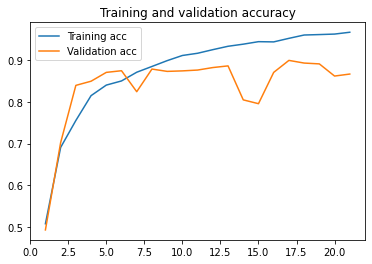

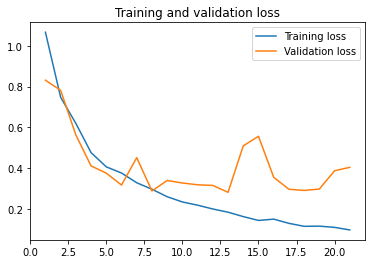

In [22]:
draw_train_graph(history)

<a name="3.1.4"></a>

### test results

In [26]:
x_test=x_test/255.0

In [24]:
model1.evaluate(x_test,y_test)

79/79 [==============================] - 8s 88ms/step - loss: 0.2571 - accuracy: 0.9171


[0.2571243941783905, 0.9171314835548401]

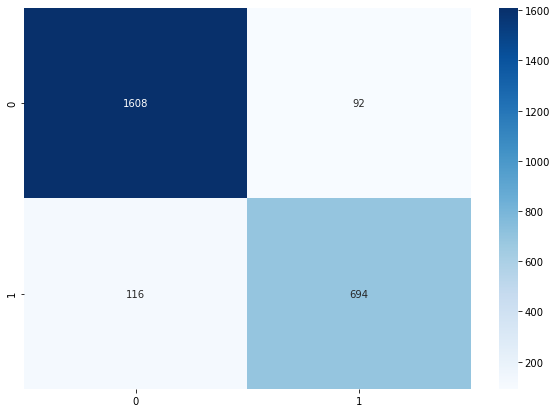

In [15]:
y_pred= model1.predict(x_test)
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [31]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

      normal       0.93      0.95      0.94      1700
    abnormal       0.88      0.86      0.87       810

    accuracy                           0.92      2510
   macro avg       0.91      0.90      0.90      2510
weighted avg       0.92      0.92      0.92      2510



In [18]:
f1_score(y_test,y_pred_rounded)

0.8696741854636593

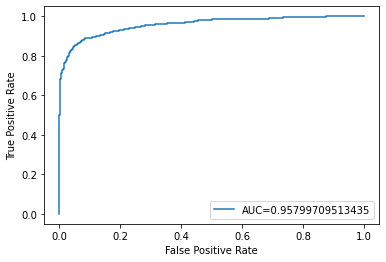

In [32]:
draw_roc(y_test,y_pred)

In [27]:
model1.save('resnet50/resnet50_model1_acc91.h5')

### try the model on oversampled data

In [14]:
train_path='D:/projects data/leukemia/oversampled'

In [15]:
train_generator ,valid_generator = create_generators(train_path)

Found 10188 images belonging to 2 classes.
Found 3394 images belonging to 2 classes.


<a name="3.2.1"></a>

### build the model

In [16]:
model2=build_model()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

<a name="3.2.2"></a>

### model complie & train

In [17]:
history= train_model(model2 ,train_generator ,valid_generator)

Epoch 1/40
637/637 [==============================] - 511s 791ms/step - loss: 1.0212 - accuracy: 0.5355 - val_loss: 0.6316 - val_accuracy: 0.6600 - lr: 1.0000e-08
Epoch 2/40
637/637 [==============================] - 126s 197ms/step - loss: 0.5784 - accuracy: 0.7778 - val_loss: 0.8008 - val_accuracy: 0.7118 - lr: 1.5005e-05
Epoch 3/40
637/637 [==============================] - 143s 224ms/step - loss: 0.4648 - accuracy: 0.8173 - val_loss: 0.2176 - val_accuracy: 0.9202 - lr: 3.0000e-05
Epoch 4/40
637/637 [==============================] - 144s 225ms/step - loss: 0.3651 - accuracy: 0.8510 - val_loss: 0.1502 - val_accuracy: 0.9443 - lr: 3.0000e-05
Epoch 5/40
637/637 [==============================] - 128s 200ms/step - loss: 0.2949 - accuracy: 0.8823 - val_loss: 0.1850 - val_accuracy: 0.9240 - lr: 2.9946e-05
Epoch 6/40
637/637 [==============================] - 128s 201ms/step - loss: 0.2733 - accuracy: 0.8908 - val_loss: 0.1903 - val_accuracy: 0.9187 - lr: 2.9784e-05
Epoch 7/40
637/637 [==

<a name="3.2.3"></a>

### train & validation loss and accuracy per epochs

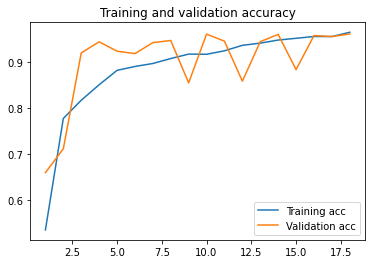

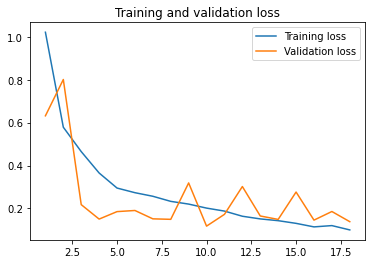

In [18]:
draw_train_graph(history)

<a name="3.2.4"></a>

### test results

In [15]:
model2.evaluate(x_test,y_test)

79/79 [==============================] - 10s 88ms/step - loss: 0.3437 - accuracy: 0.9064


[0.3437386751174927, 0.9063745141029358]

In [10]:
y_pred= model2.predict(x_test)

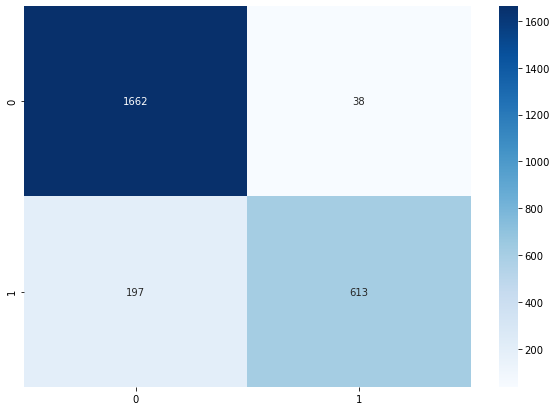

In [17]:
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [19]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

      normal       0.89      0.98      0.93      1700
    abnormal       0.94      0.76      0.84       810

    accuracy                           0.91      2510
   macro avg       0.92      0.87      0.89      2510
weighted avg       0.91      0.91      0.90      2510



In [21]:
f1_score(y_test,y_pred_rounded)

0.8391512662559891

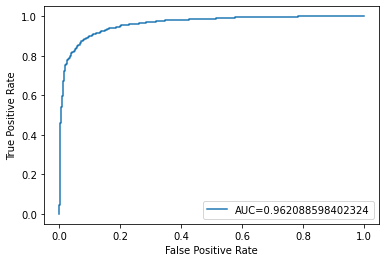

In [11]:
draw_roc(y_test,y_pred)

In [9]:
model2.save('resnet50/Resnet50_model2_acc_91.h5')

### try the model on undersampled data

In [10]:
train_path='D:/projects data/leukemia/undersampled'

In [11]:
train_generator,valid_generator = create_generators(train_path)

Found 4842 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


<a name="3.3.1"></a>

### build the model

In [12]:
model3=build_model()
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

<a name="3.3.2"></a>

### model complie & train

In [13]:
history= train_model(model3 ,train_generator ,valid_generator)

Epoch 1/40
303/303 [==============================] - 158s 495ms/step - loss: 1.0648 - accuracy: 0.5072 - val_loss: 0.7931 - val_accuracy: 0.5087 - lr: 1.0000e-08
Epoch 2/40
303/303 [==============================] - 82s 270ms/step - loss: 0.7751 - accuracy: 0.6840 - val_loss: 0.5572 - val_accuracy: 0.7736 - lr: 1.5005e-05
Epoch 3/40
303/303 [==============================] - 82s 270ms/step - loss: 0.6793 - accuracy: 0.7398 - val_loss: 0.5119 - val_accuracy: 0.7916 - lr: 3.0000e-05
Epoch 4/40
303/303 [==============================] - 65s 215ms/step - loss: 0.5550 - accuracy: 0.7856 - val_loss: 0.5209 - val_accuracy: 0.8139 - lr: 3.0000e-05
Epoch 5/40
303/303 [==============================] - 81s 267ms/step - loss: 0.4809 - accuracy: 0.8075 - val_loss: 0.3949 - val_accuracy: 0.8474 - lr: 2.9946e-05
Epoch 6/40
303/303 [==============================] - 64s 209ms/step - loss: 0.4145 - accuracy: 0.8337 - val_loss: 0.5772 - val_accuracy: 0.7971 - lr: 2.9784e-05
Epoch 7/40
303/303 [=======

<a name="3.3.3"></a>

### train & validation loss and accuracy per epochs

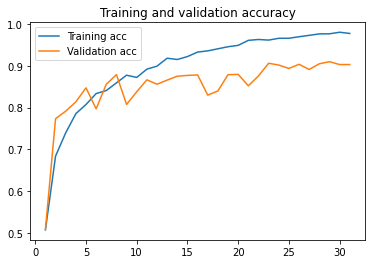

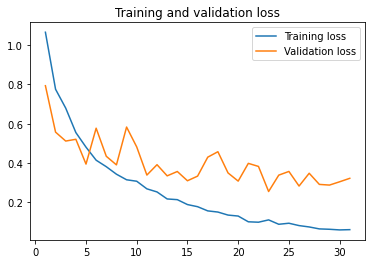

In [14]:
draw_train_graph(history)

<a name="3.3.4"></a>

### test results

In [16]:
model3.evaluate(x_test,y_test)

79/79 [==============================] - 7s 83ms/step - loss: 0.3113 - accuracy: 0.9040


[0.3113050162792206, 0.9039840698242188]

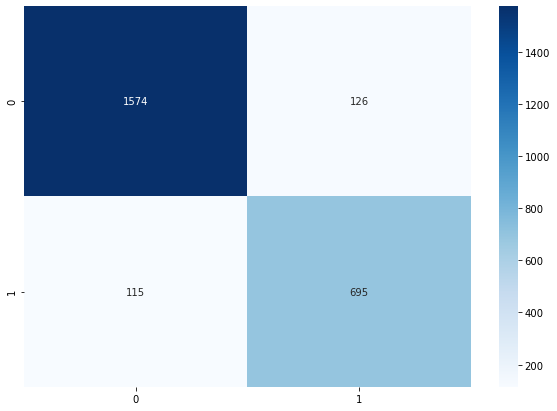

In [10]:
y_pred= model3.predict(x_test)
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [11]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

      normal       0.93      0.93      0.93      1700
    abnormal       0.85      0.86      0.85       810

    accuracy                           0.90      2510
   macro avg       0.89      0.89      0.89      2510
weighted avg       0.90      0.90      0.90      2510



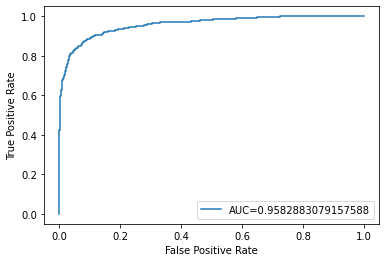

In [12]:
draw_roc(y_test,y_pred)

In [13]:
f1_score(y_test,y_pred_rounded)

0.8522378908645003

In [17]:
model3.save('resnet50/Resnet50_model3_acc_90.h5')